In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
import torchvision
from glob import glob
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import numpy as np
import os
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset, DataLoader, random_split, Dataset
from torchvision.io import read_image
from torch.autograd import Variable

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

In [ ]:
train_path = glob("/content/drive/MyDrive/cityscapes_data/train/*")
valid_path = glob("/content/drive/MyDrive/cityscapes_data/val/*")

In [ ]:
train_dataset = []
valid_dataset = []
#torch.utils.data.Dataset/Dataloader
class dataset(Dataset):
    def __init__(self, image_path, transform_img = None, transform_label = None):
        self.image_path = image_path
        self.transform_img = transform_img
        self.transform_label = transform_label

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        img = plt.imread(self.image_path[idx])

        image, label = img[:,:img.shape[1]//2], img[:,img.shape[1]//2:]

        if self.transform_img:
            image = self.transform_img(image)

        if self.transform_label:
            label = self.transform_label(label)

        return image, label

In [ ]:
z_size = 10 # Size of z latent vector (i.e. size of generator input)
img_size = 64
ngpu = 16 # Number of GPUs available
nc = 3   # Number of channels in the training images. For color images this is 3

In [ ]:
myTransformImage = transform.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size,img_size)),
    transform.ToTensor(),
#     transform.RandomHorizontalFlip(p = 0.9)
])

myTransformLabel = transform.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size,img_size)),
    transform.ToTensor(),
])

In [ ]:
train_dataset = dataset(train_path, myTransformImage, myTransformLabel)
valid_dataset = dataset(valid_path, myTransformImage, myTransformLabel)


# Batches
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle = True)

In [ ]:
#Print batch
def show_batch(whole_batch):
    images, ground_truths = whole_batch[0], whole_batch[1]
    images = images.numpy()
    ground_truths = ground_truths.numpy()
    fig, axes = plt.subplots(2, batch_size, figsize=(36, 4))

    for i in range(batch_size):
        axes[0, i].imshow(np.transpose(images[i], (1, 2, 0)))
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Input{i}')

        axes[1, i].imshow(np.transpose(ground_truths[i], (1, 2, 0)))
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Output{i}')

    plt.show()

In [ ]:
data_iter = iter(train_loader)
show_batch(next(data_iter))

In [ ]:
#visualize images, pass the list

def show(pckt):

    iters = 1
    if len(pckt[0].shape) > 3:
        iters = pckt[0].shape[0]
        for j in range(iters):
            img = [None]*3
            n = 3
            labels = ['Label', 'Real', 'Predicted']
            fig, ax = plt.subplots(1, n, figsize=(10, 30))
            for i in range(n):

                x = torch.Tensor.cpu(pckt[j][i])
                x = x.detach().numpy()
                ax[i].imshow(np.transpose(x,(1,2,0)))
                ax[i].set_title(labels[i])
    else:
        img = [None]*3
        n = len(pckt)
        labels = ['Input', 'Output', 'Predicted']
        fig, ax = plt.subplots(1, n, figsize=(10, 30))
        for i in range(n):
            x = torch.Tensor.cpu(pckt[i])
            x = x.detach().numpy()
            ax[i].imshow(np.transpose(x,(1,2,0)))
            ax[i].set_title(labels[i])

In [ ]:
data_iter = iter(train_loader)
input, output = next(data_iter)

show([input[0], output[0]])
print(input.shape)

In [ ]:
ngf = 64
class Generator(nn.Module):
    def __init__(self,ngf, img_size, nc):
        super().__init__()
        self.nc = nc
        self.img_size = img_size
        self.ngf = ngf

        self.downSampling = nn.Sequential(
            nn.Conv2d(nc, self.ngf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.ngf, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.ngf * 2, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.ngf * 4, self.ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.ngf * 8, self.ngf * 16, 4, 1, 0, bias=False),
        )

        self.upSampling = nn.Sequential(
            nn.ConvTranspose2d( self.ngf * 16, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf*2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):

        x = self.downSampling(input)
        # print(x.shape)

        # Generator out
        out = self.upSampling(x)
        # print(out.shape)
        return out
myGenerator = Generator(ngf, img_size, nc).to(device)

In [ ]:
data_iter = iter(train_loader)
input, output = next(data_iter)
input = input.to(device)
# print(random_noise.shape)
# print(img_label.view(16, -1).shape)
# Forward pass through the generator
generated_image = myGenerator(input).data.cpu()
# print(generated_image.shape)
print(len(generated_image))
# Show images
grid = make_grid(generated_image, nrow=4, normalize=True).permute(1,2,0).numpy()
plt.imshow(grid)
plt.show()

In [ ]:
ndf = 64
class Discriminator(nn.Module):
    def __init__(self, ngpu, img_size, nc):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.img_size = img_size
        self.nc = nc

        self.main = nn.Sequential(

            nn.Conv2d(nc*2, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()

        )

    def forward(self, x, labels):

        # Concat image & label
        x = torch.cat([x, labels], 1)
        # print(x.shape)
        # Discriminator out
        out = self.main(x)
        # print(out.shape)
        return out.view(-1,1,1,1)


myDiscriminator = Discriminator(ngpu, img_size, nc).to(device)

In [ ]:
# Generate random noise and labels
data_iter = iter(train_loader)
input, output = next(data_iter)
input = input.to(device)
output = output.to(device)
# Forward pass through the generator
generated_image = myGenerator(input).data.cpu().to(device)
# Disciminating fake images
fake_validity = myDiscriminator(input, generated_image)
print(fake_validity.shape)

In [ ]:
def weights_init(m):  #custom weights initialization called on myGenerator and myDiscriminator
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

myGenerator.apply(weights_init)
myDiscriminator.apply(weights_init)

In [ ]:
# Setup Adam optimizers for both G and D
d_optimizer = optim.Adam(myDiscriminator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
g_optimizer = optim.Adam(myGenerator.parameters(), lr = 0.0002, betas = (0.5, 0.999))
# Initialize BCELoss function
criterion  = nn.BCELoss()

Starting Training Loop...
Starting epoch 1...
g_loss: 0.8465336561203003, d_loss: 1.5421972274780273


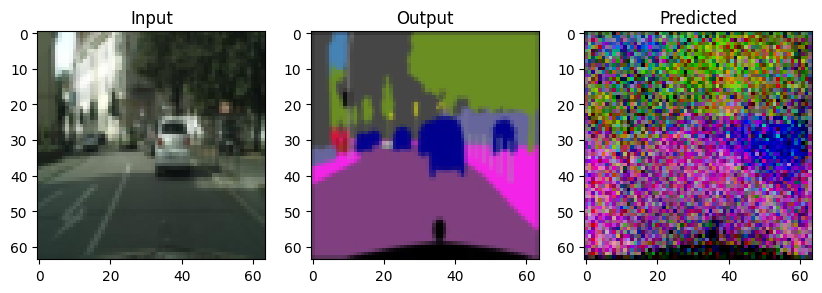

Starting epoch 2...


g_loss: 1.1427124738693237, d_loss: 1.2781480550765991


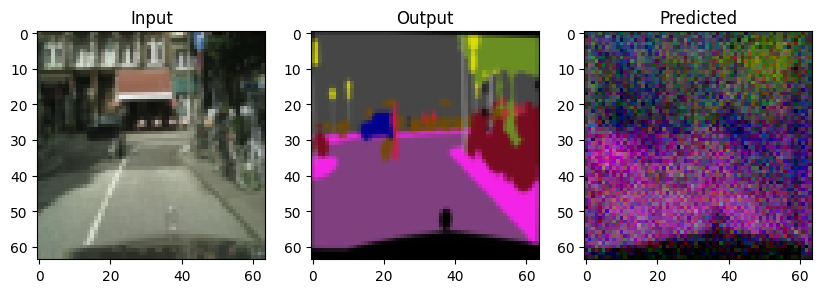

Starting epoch 3...
g_loss: 1.084282636642456, d_loss: 1.0587332248687744


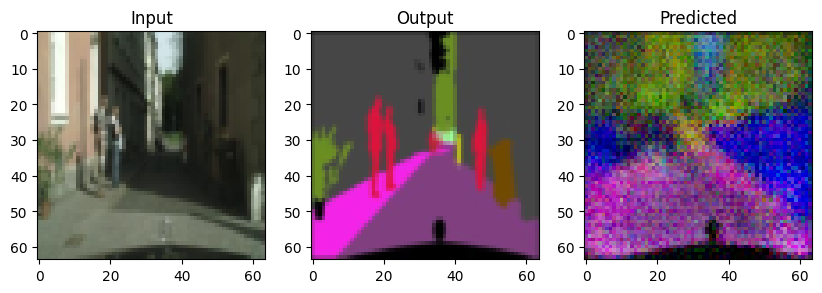

Starting epoch 4...


g_loss: 2.3436837196350098, d_loss: 1.646231770515442


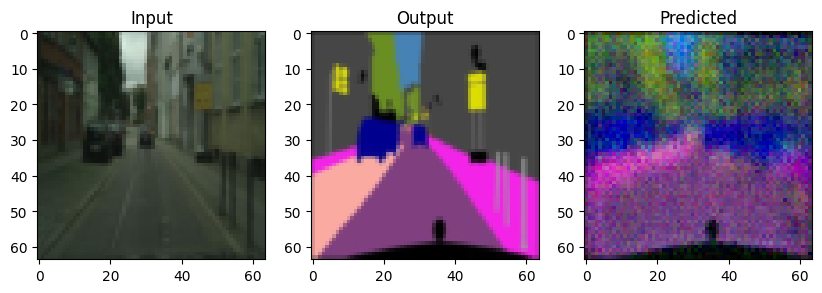

Starting epoch 5...


g_loss: 0.24921226501464844, d_loss: 1.4378080368041992


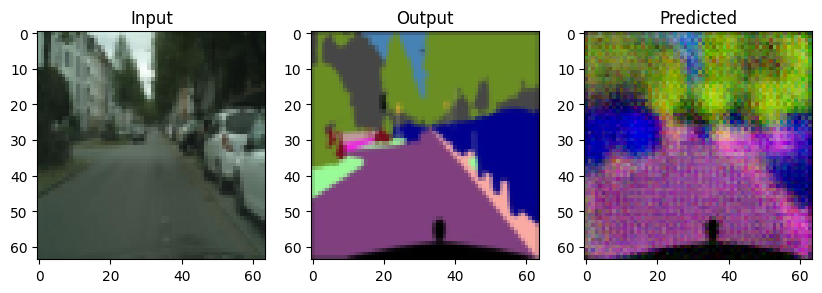

Starting epoch 6...


g_loss: 1.4563955068588257, d_loss: 1.017115592956543


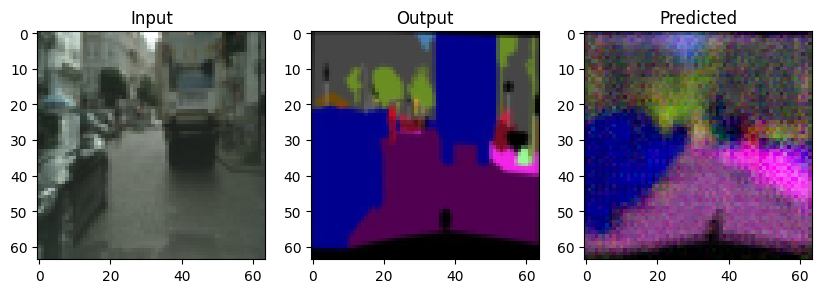

Starting epoch 7...


g_loss: 0.2012665867805481, d_loss: 1.369430422782898


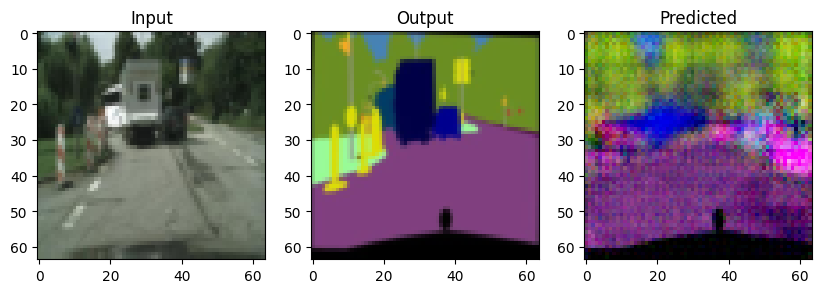

Starting epoch 8...
g_loss: 0.29363352060317993, d_loss: 1.446907639503479


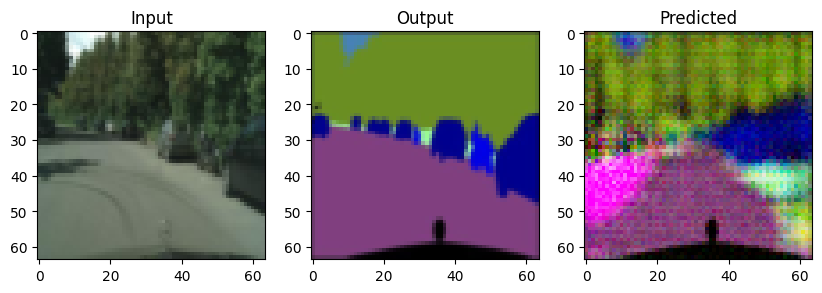

Starting epoch 9...


g_loss: 4.449392318725586, d_loss: 1.0433634519577026


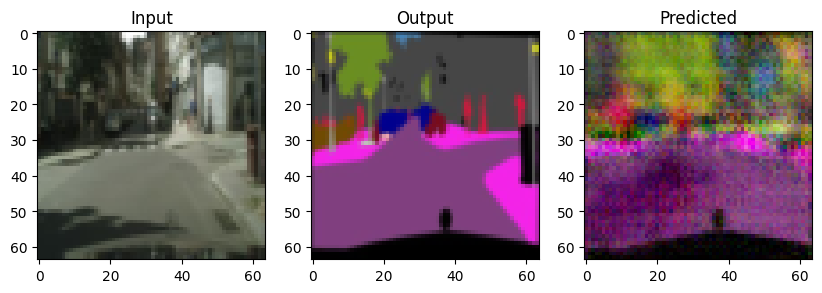

Starting epoch 10...


g_loss: 0.7069140076637268, d_loss: 1.036336064338684


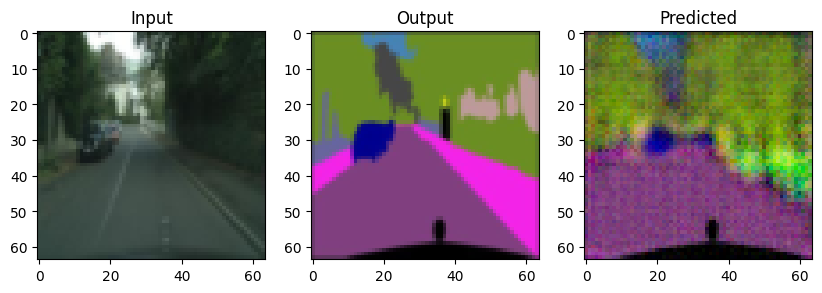

Starting epoch 11...
g_loss: 0.41412824392318726, d_loss: 1.4098942279815674


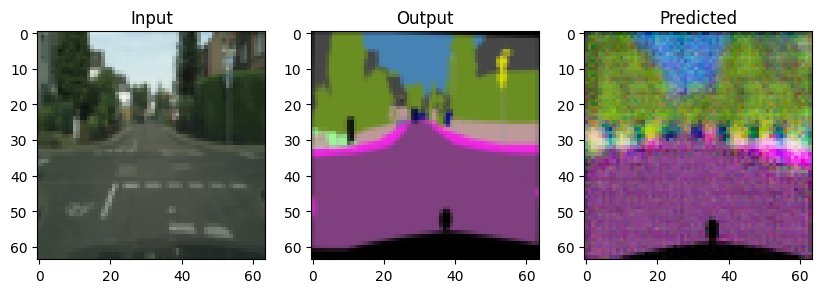

Starting epoch 12...


g_loss: 1.0985667705535889, d_loss: 0.8297441601753235


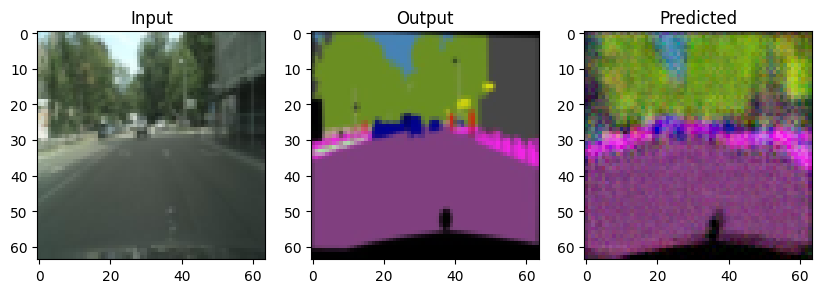

Starting epoch 13...


g_loss: 3.583268165588379, d_loss: 0.9616012573242188


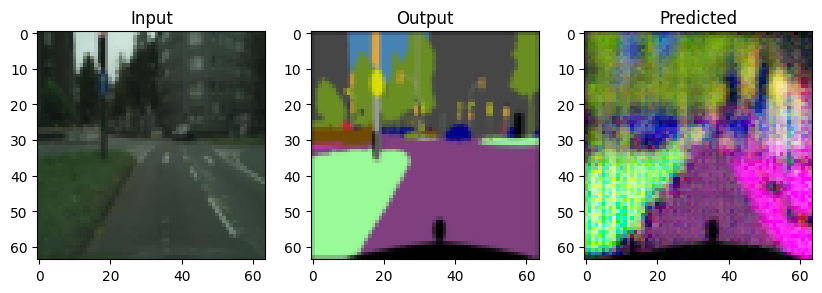

Starting epoch 14...
g_loss: 1.1938689947128296, d_loss: 0.7678093910217285


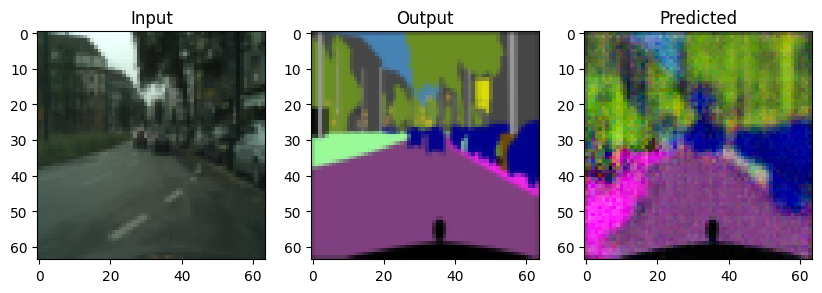

Starting epoch 15...


g_loss: 1.132525086402893, d_loss: 0.7545408010482788


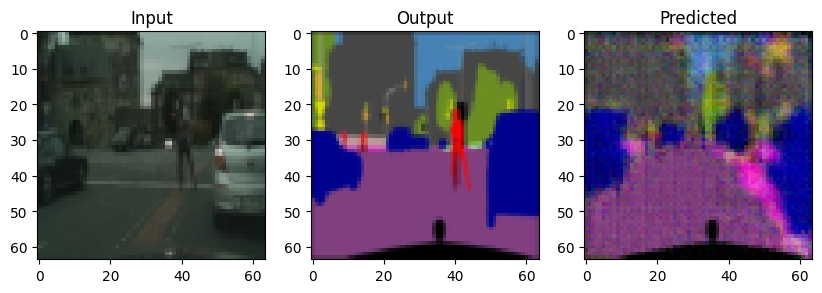

Starting epoch 16...


g_loss: 0.8632297515869141, d_loss: 0.8868786096572876


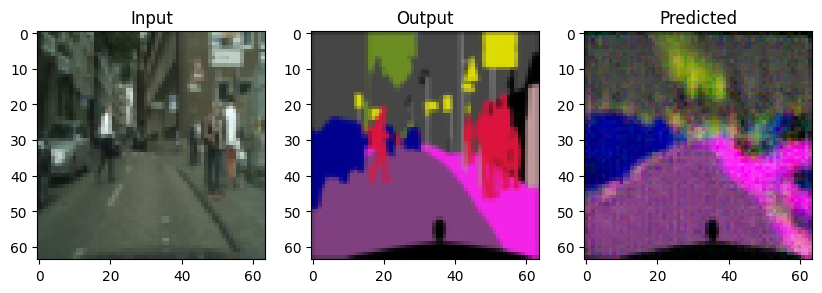

Starting epoch 17...
g_loss: 2.404367446899414, d_loss: 0.28197211027145386


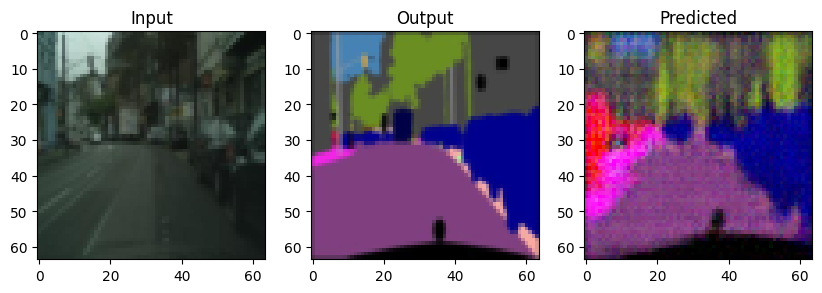

Starting epoch 18...


g_loss: 0.2989366948604584, d_loss: 2.333270311355591


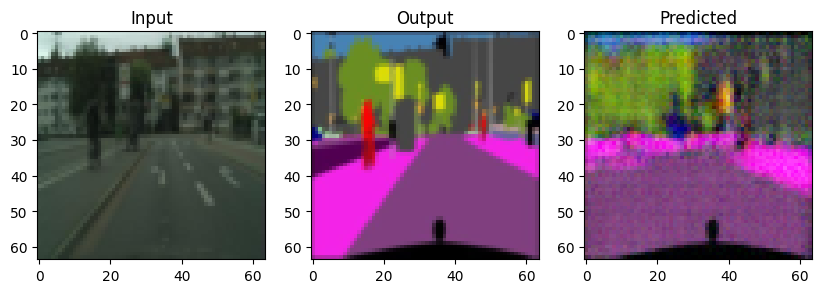

Starting epoch 19...


g_loss: 1.9058783054351807, d_loss: 0.5113434791564941


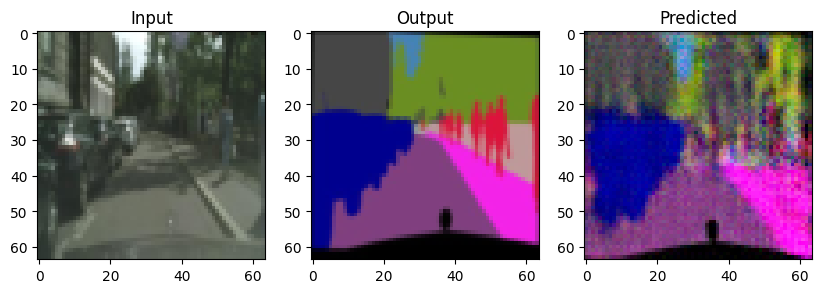

Starting epoch 20...
g_loss: 0.08102606236934662, d_loss: 1.5174628496170044


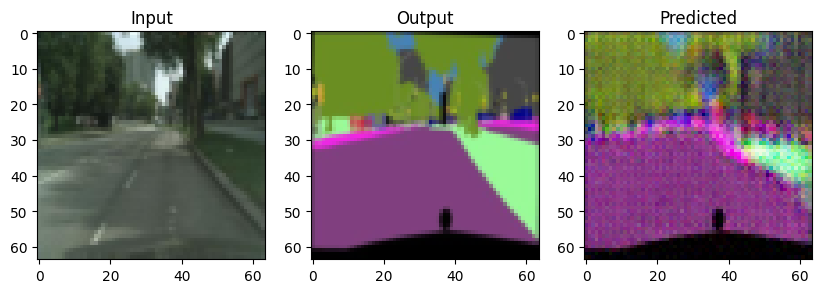

Starting epoch 21...


g_loss: 0.1433875858783722, d_loss: 1.0684641599655151


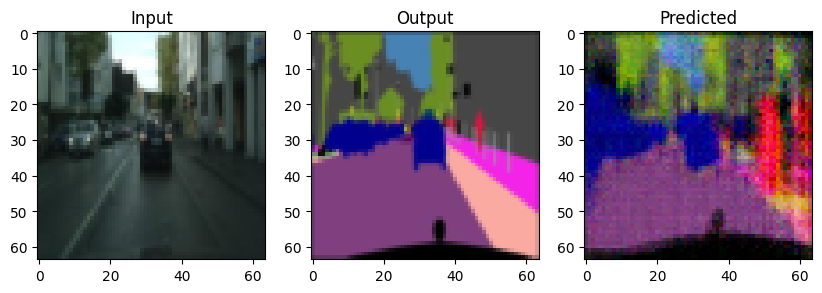

Starting epoch 22...


g_loss: 4.62741756439209, d_loss: 0.7180562019348145


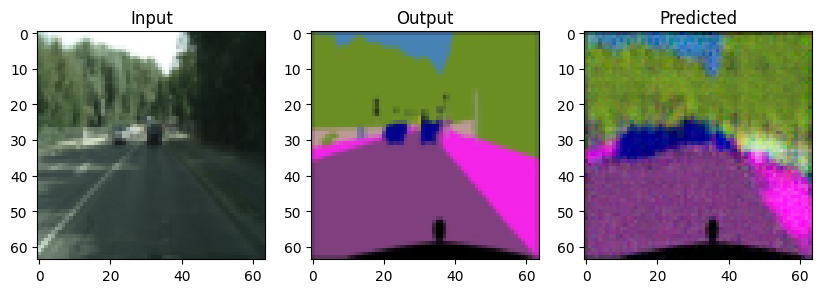

Starting epoch 23...
g_loss: 2.800856828689575, d_loss: 1.1030113697052002


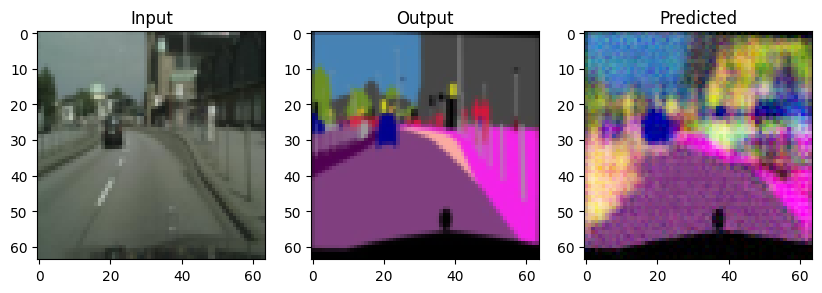

Starting epoch 24...


g_loss: 2.7751641273498535, d_loss: 0.6281077861785889


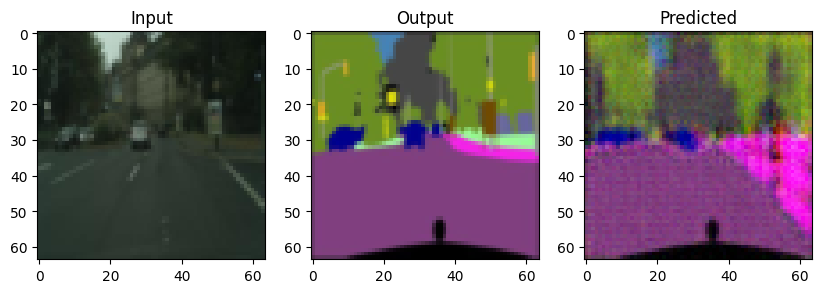

Starting epoch 25...


g_loss: 5.922957420349121, d_loss: 0.8290799856185913


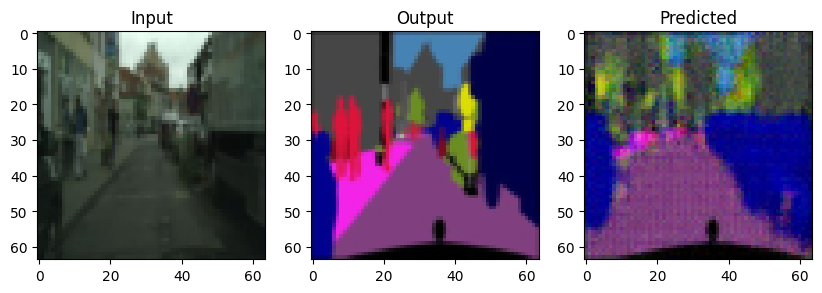

Starting epoch 26...


g_loss: 0.23272240161895752, d_loss: 0.9261112213134766


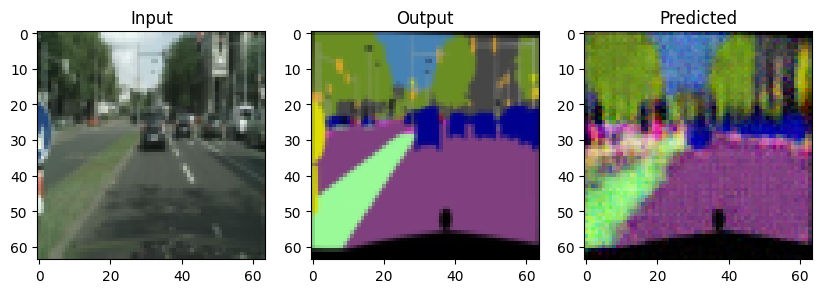

Starting epoch 27...
g_loss: 6.147869110107422, d_loss: 0.6599724888801575


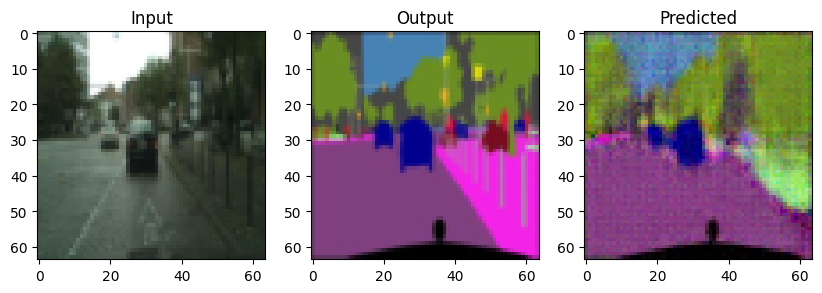

Starting epoch 28...


g_loss: 2.556110382080078, d_loss: 0.6005598306655884


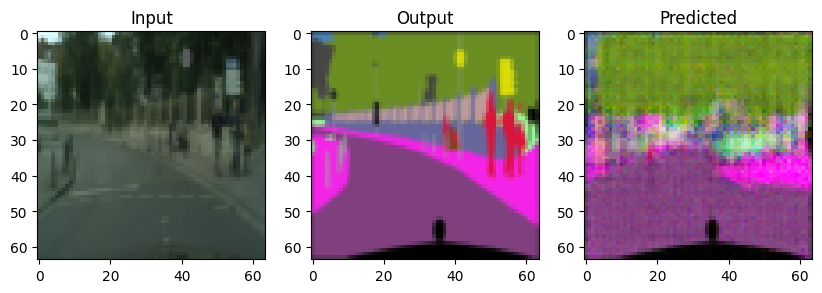

Starting epoch 29...


g_loss: 0.4191644489765167, d_loss: 0.7180318236351013


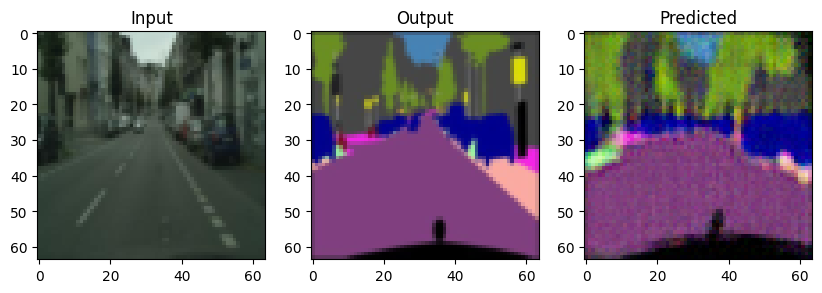

Starting epoch 30...
g_loss: 0.245782271027565, d_loss: 0.7611827850341797


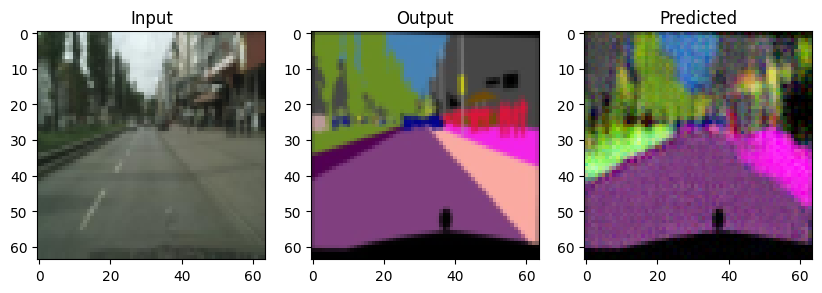

Starting epoch 31...


g_loss: 1.993006706237793, d_loss: 0.5981955528259277


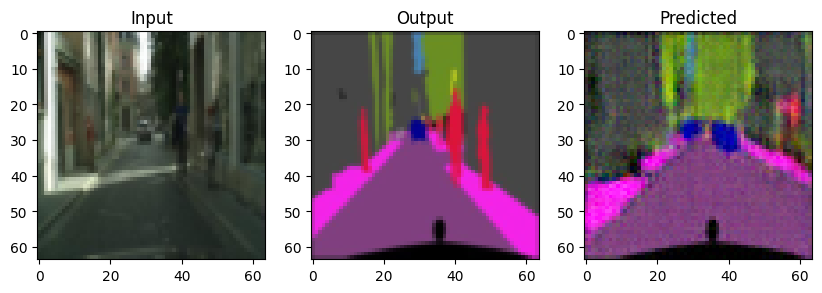

Starting epoch 32...


g_loss: 6.212337970733643, d_loss: 0.7135136127471924


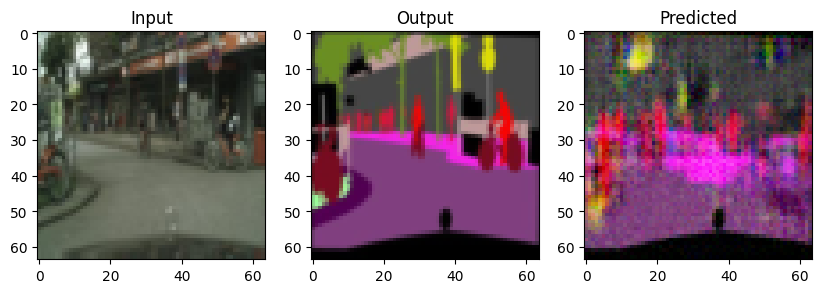

Starting epoch 33...
g_loss: 1.949996829032898, d_loss: 0.6762235164642334


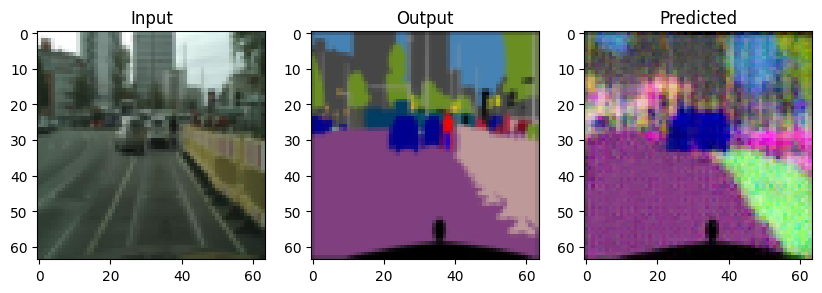

Starting epoch 34...


g_loss: 0.9386374354362488, d_loss: 0.7564674019813538


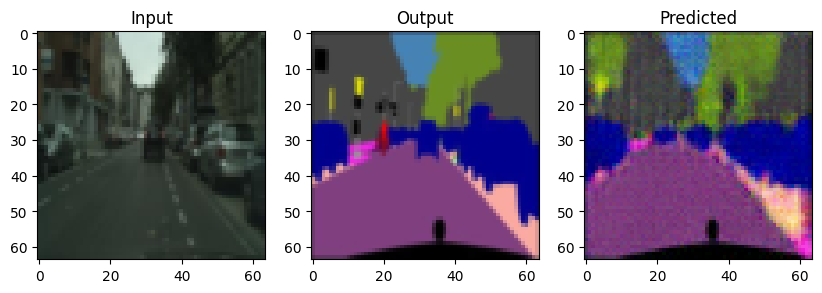

Starting epoch 35...


g_loss: 3.7183146476745605, d_loss: 0.3981071710586548


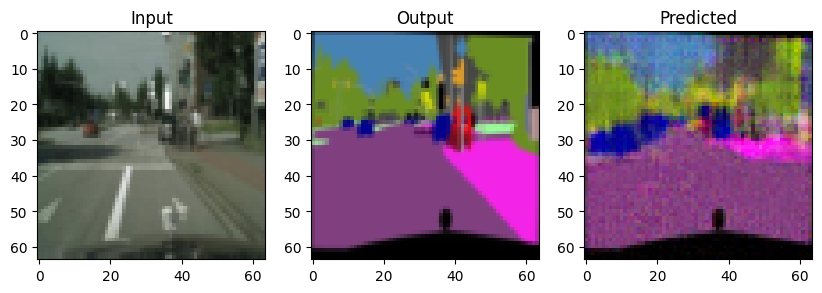

Starting epoch 36...


g_loss: 0.6267666220664978, d_loss: 1.0277891159057617


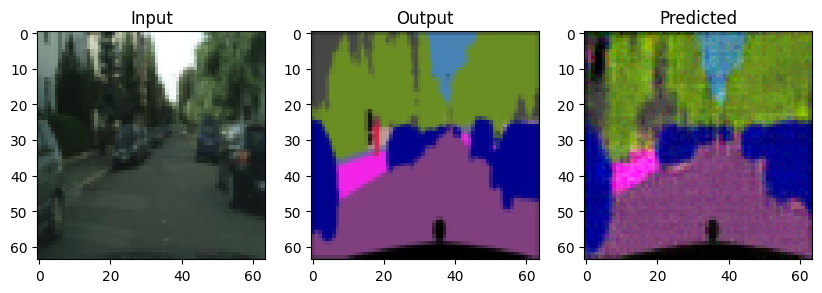

Starting epoch 37...


g_loss: 0.015188399702310562, d_loss: 2.3983073234558105


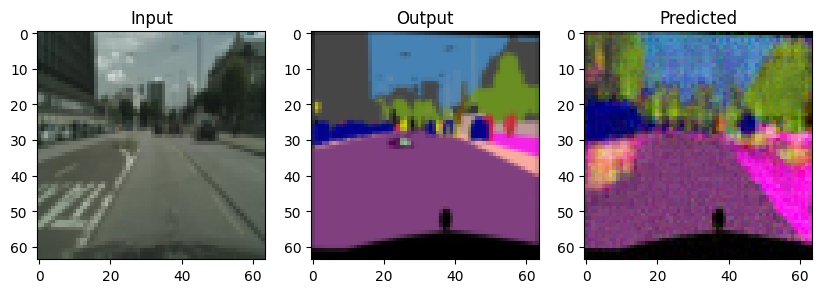

Starting epoch 38...


g_loss: 4.404539108276367, d_loss: 0.6612141132354736


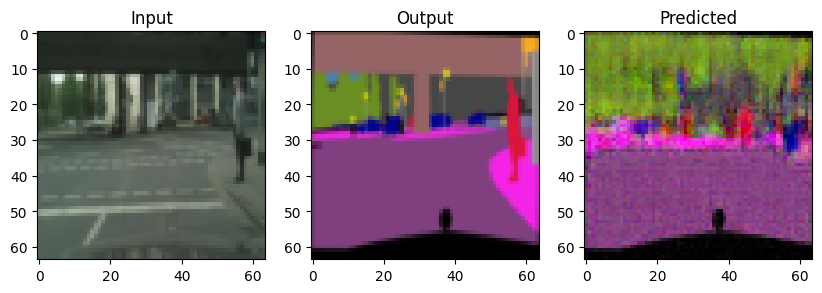

Starting epoch 39...
g_loss: 0.23912270367145538, d_loss: 1.2129191160202026


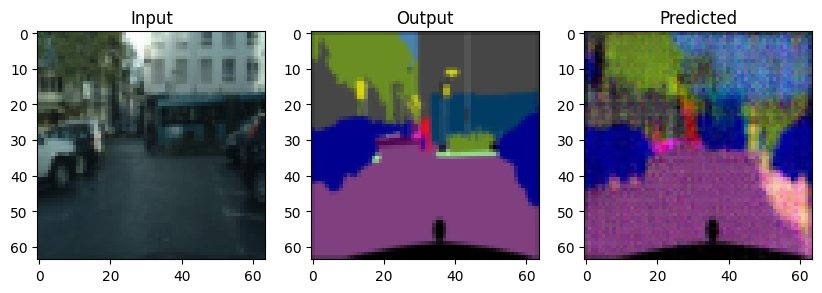

Starting epoch 40...
g_loss: 3.2532010078430176, d_loss: 0.3623347878456116


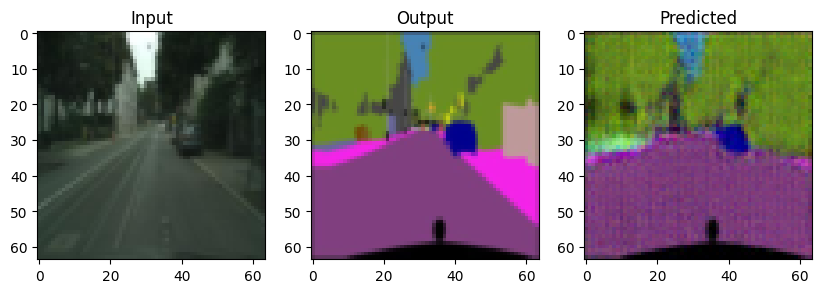

Starting epoch 41...


g_loss: 4.563539505004883, d_loss: 0.5936577320098877


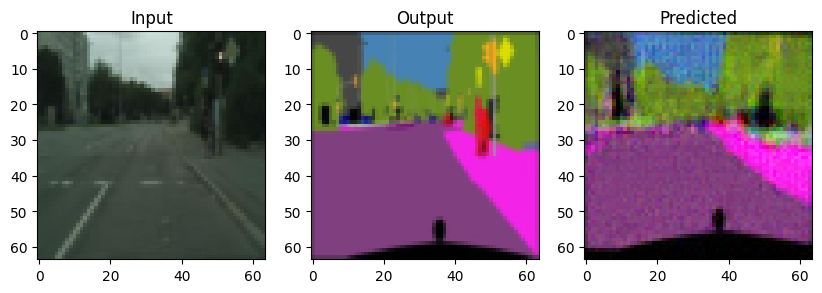

Starting epoch 42...
g_loss: 0.24517357349395752, d_loss: 0.5740271806716919


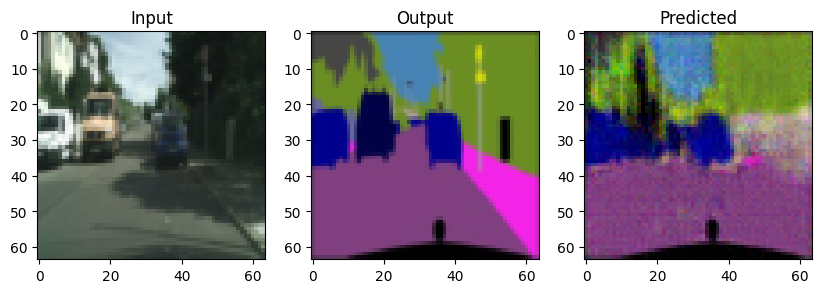

Starting epoch 43...


g_loss: 1.908167839050293, d_loss: 0.4103326201438904


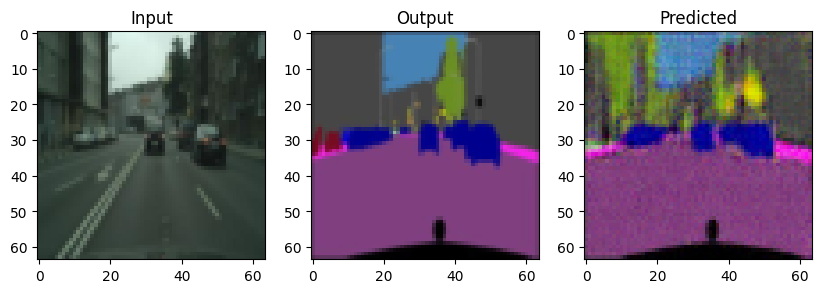

Starting epoch 44...


g_loss: 1.764256238937378, d_loss: 0.4110579192638397


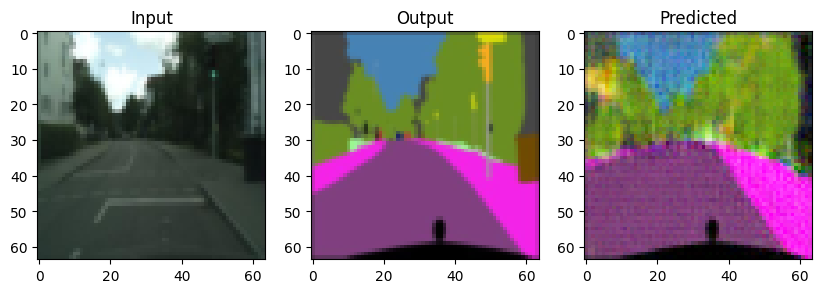

Starting epoch 45...


g_loss: 1.3947958946228027, d_loss: 0.3859426975250244


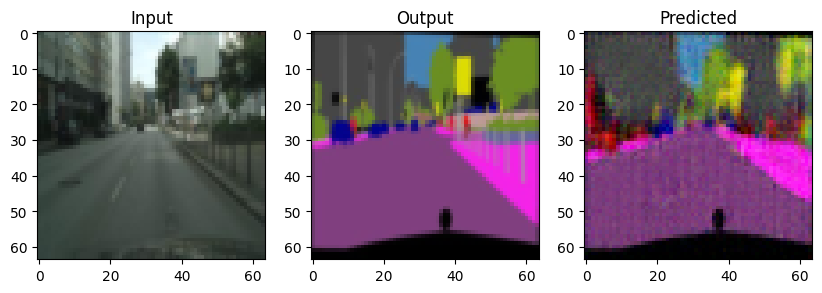

Starting epoch 46...


g_loss: 6.354893684387207, d_loss: 0.33696919679641724


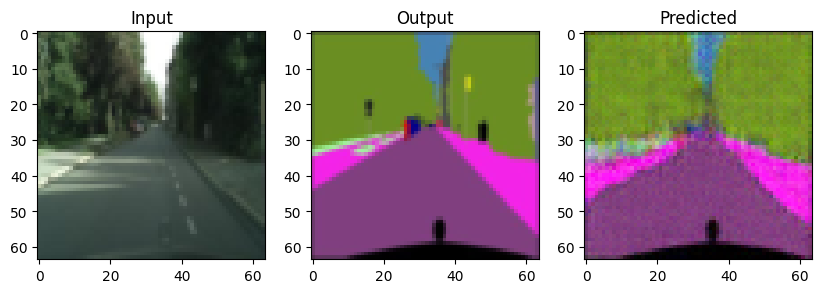

Starting epoch 47...


g_loss: 0.6821714639663696, d_loss: 1.0566085577011108


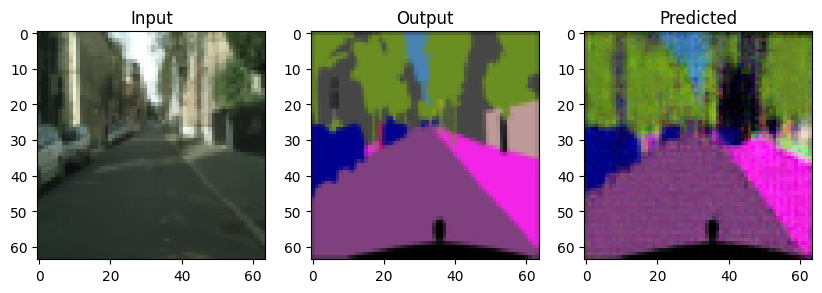

Starting epoch 48...


g_loss: 0.07551942765712738, d_loss: 1.3193873167037964


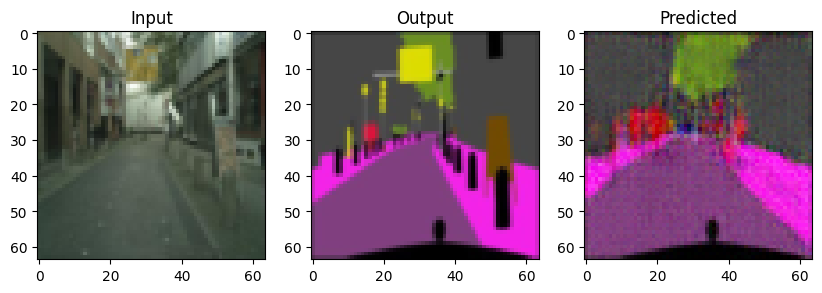

Starting epoch 49...
g_loss: 2.799687385559082, d_loss: 0.44108518958091736


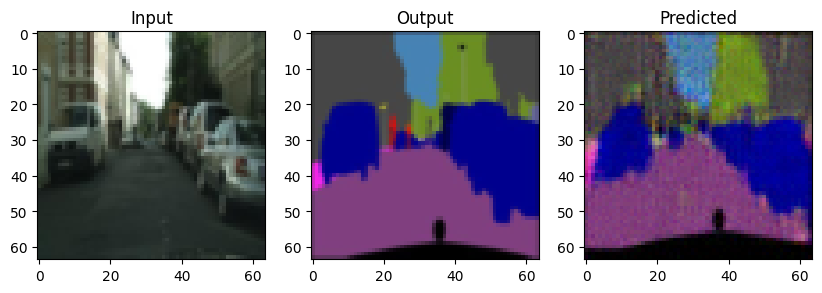

Starting epoch 50...


g_loss: 6.8063812255859375, d_loss: 0.47675395011901855


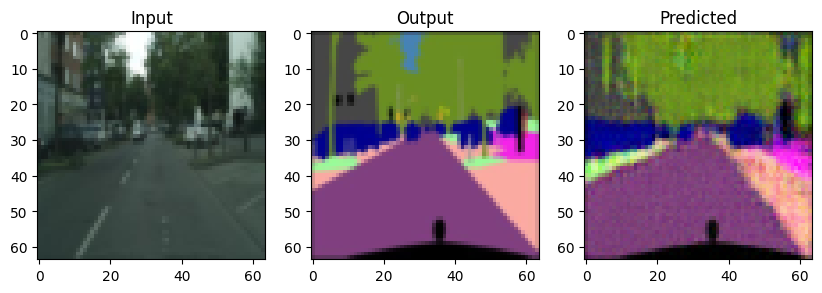

Starting epoch 51...


g_loss: 5.505354881286621, d_loss: 0.3794771134853363


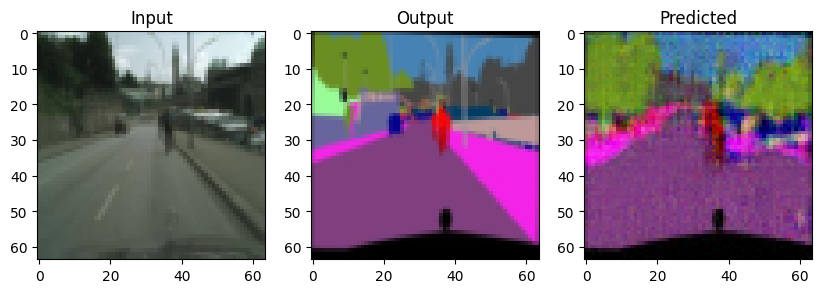

Starting epoch 52...
g_loss: 3.0810976028442383, d_loss: 0.5456194877624512


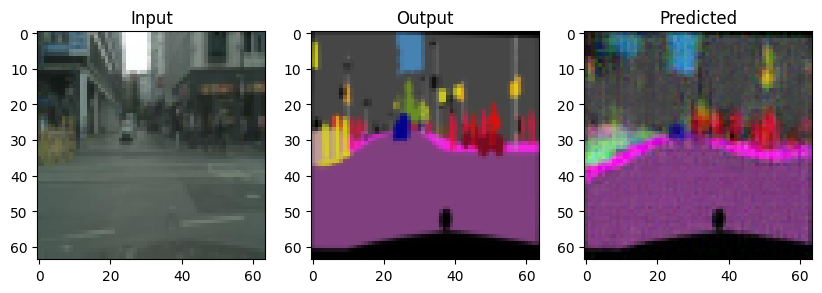

Starting epoch 53...


g_loss: 2.232370376586914, d_loss: 0.3456462621688843


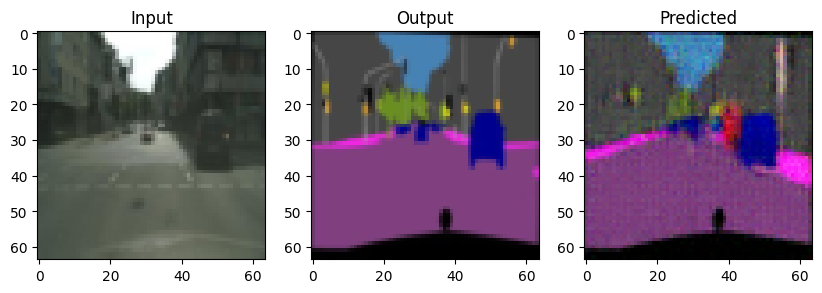

Starting epoch 54...


g_loss: 0.09249449521303177, d_loss: 1.0226207971572876


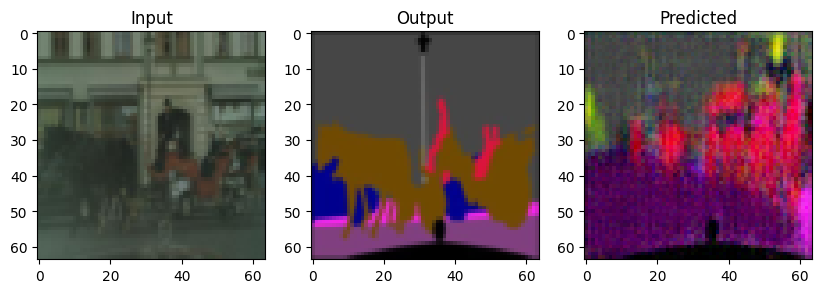

Starting epoch 55...
g_loss: 3.4802968502044678, d_loss: 0.6042637825012207


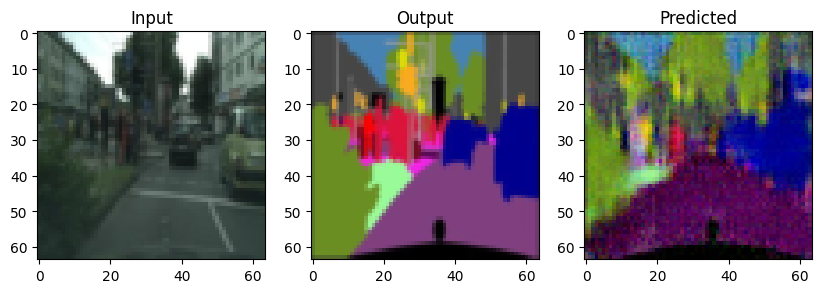

Starting epoch 56...


g_loss: 1.3234119415283203, d_loss: 0.44418033957481384


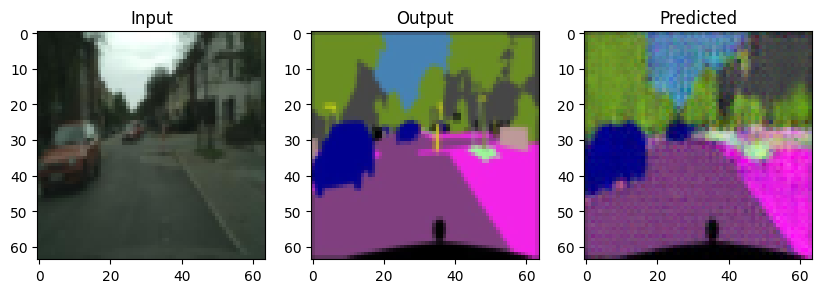

Starting epoch 57...


g_loss: 1.1681568622589111, d_loss: 0.5824575424194336


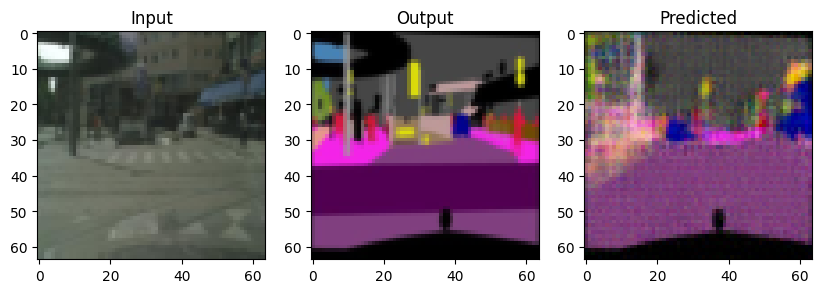

Starting epoch 58...
g_loss: 0.1814802885055542, d_loss: 0.9594727754592896


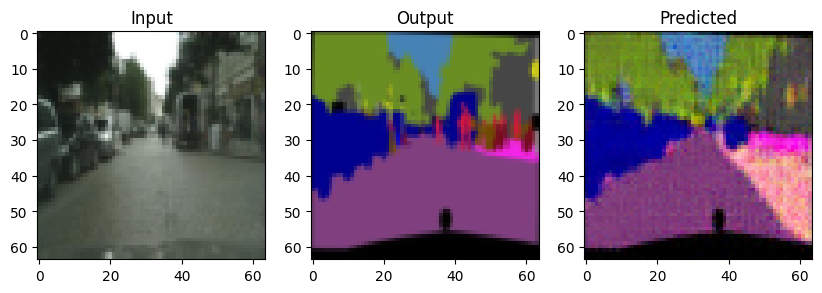

Starting epoch 59...


g_loss: 2.3434712886810303, d_loss: 1.3170872926712036


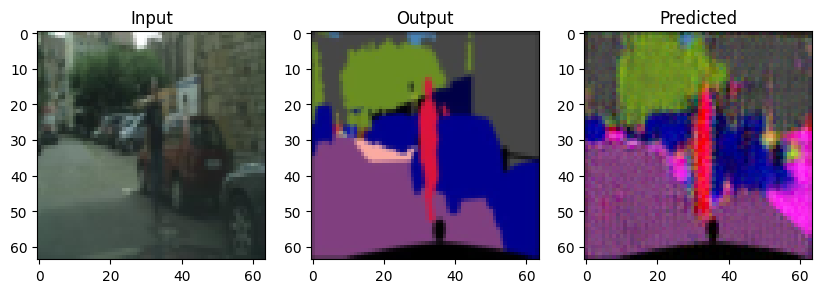

Starting epoch 60...


g_loss: 0.33548372983932495, d_loss: 0.9324055910110474


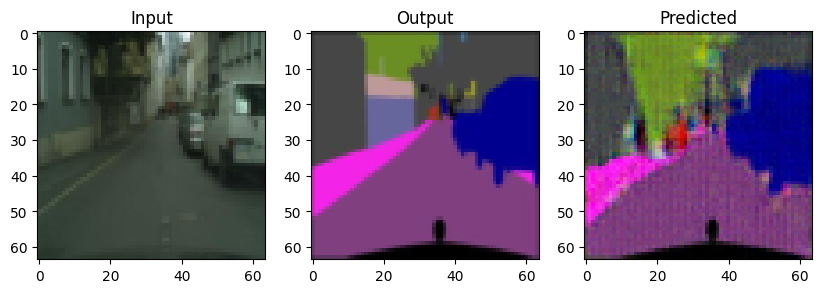

Starting epoch 61...
g_loss: 12.215797424316406, d_loss: 1.616601586341858


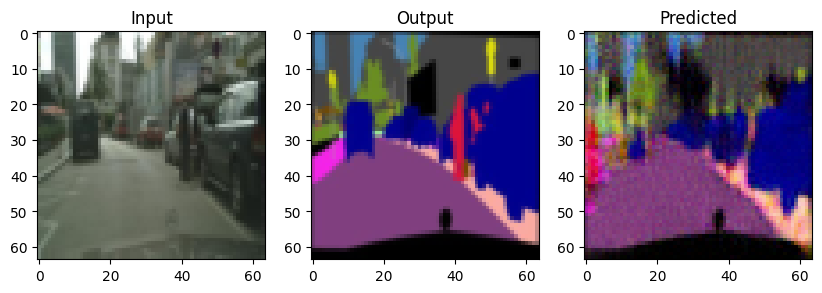

Starting epoch 62...


g_loss: 5.859682559967041, d_loss: 0.6348313093185425


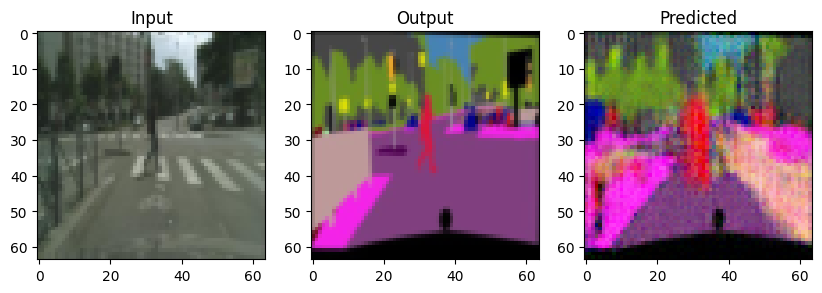

Starting epoch 63...


g_loss: 1.489953875541687, d_loss: 1.1382439136505127


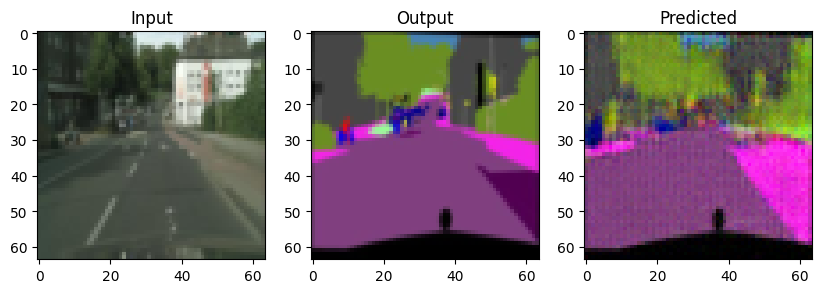

Starting epoch 64...


g_loss: 0.001975726569071412, d_loss: 2.6764137744903564


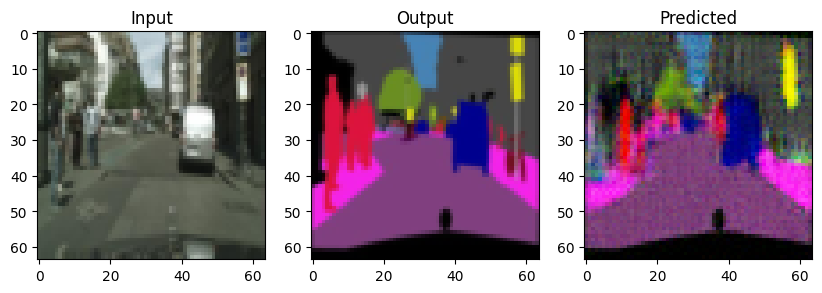

Starting epoch 65...


g_loss: 9.285294532775879, d_loss: 1.513864278793335


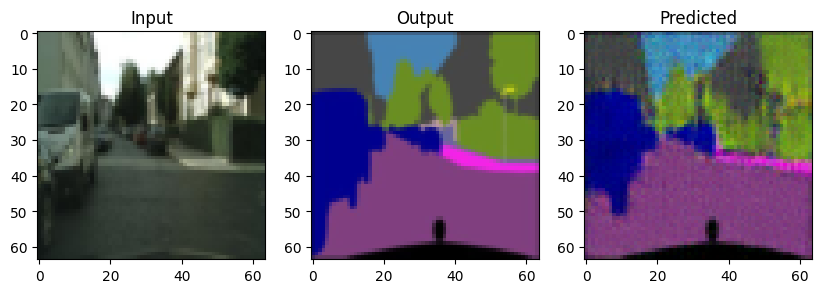

Starting epoch 66...


g_loss: 0.05272336304187775, d_loss: 1.9158215522766113


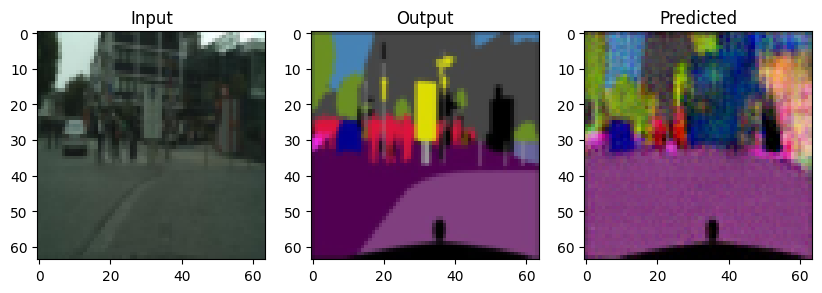

Starting epoch 67...


g_loss: 8.009836196899414, d_loss: 0.9242138862609863


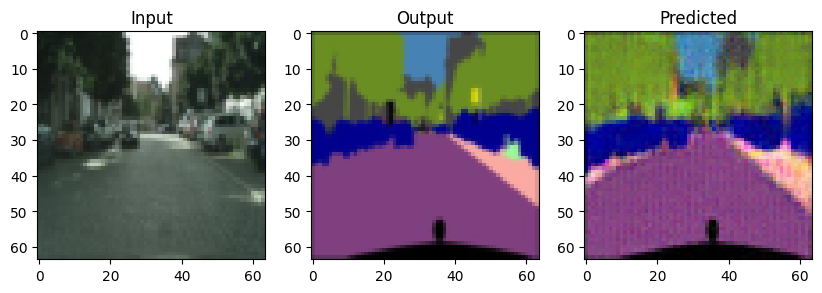

Starting epoch 68...
g_loss: 0.7281358242034912, d_loss: 0.9309307336807251


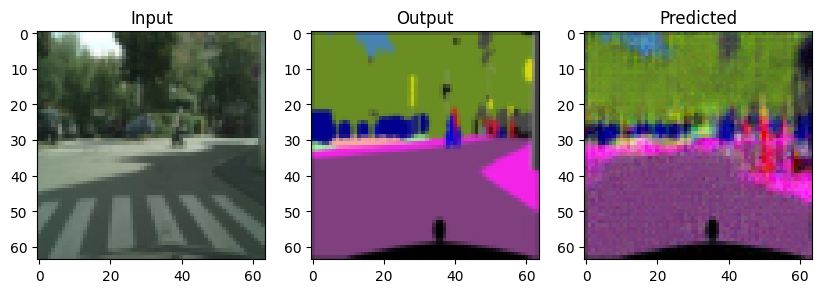

Starting epoch 69...


g_loss: 4.267735481262207, d_loss: 0.37471628189086914


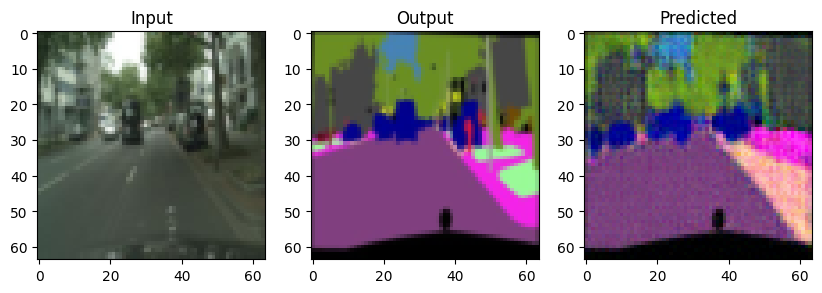

Starting epoch 70...


g_loss: 6.360754489898682, d_loss: 0.35271772742271423


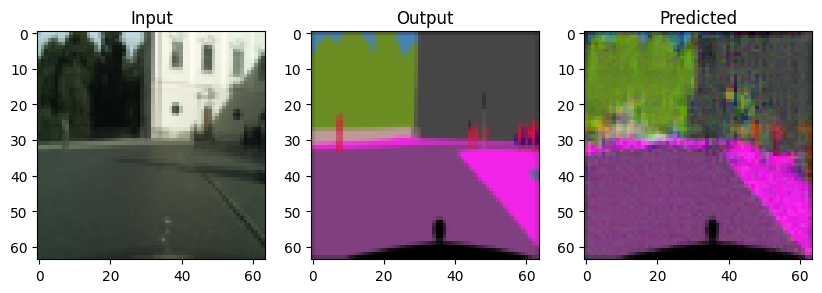

Starting epoch 71...
g_loss: 3.2056634426116943, d_loss: 0.4528447389602661


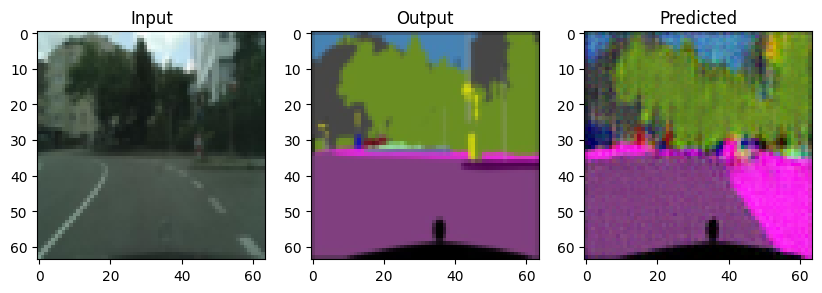

Starting epoch 72...


g_loss: 7.589522361755371, d_loss: 0.684066653251648


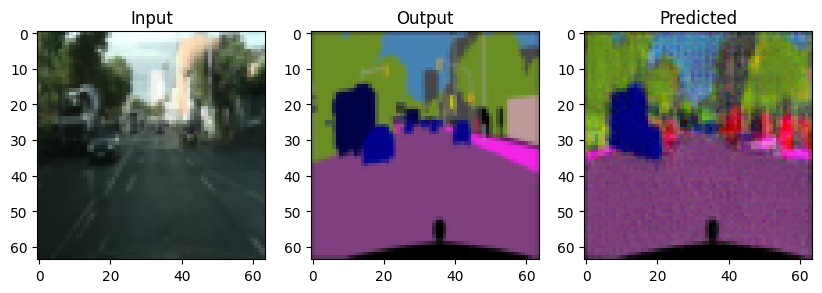

Starting epoch 73...
g_loss: 0.010099003091454506, d_loss: 1.7258455753326416


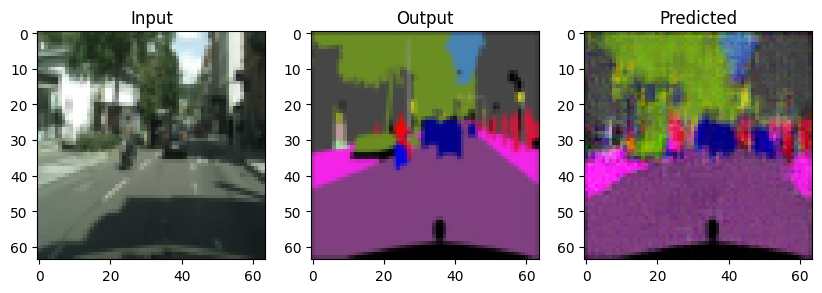

Starting epoch 74...
g_loss: 2.3463332653045654, d_loss: 0.23894202709197998


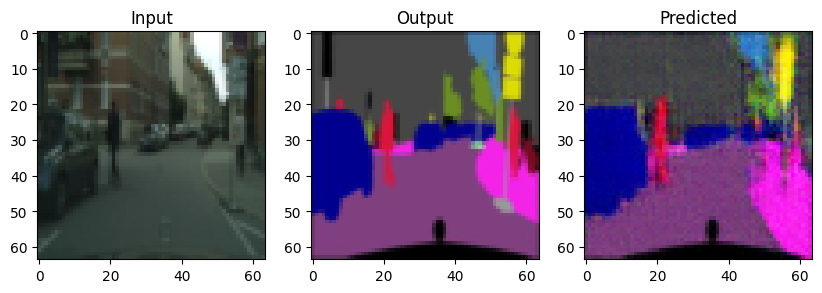

Starting epoch 75...


g_loss: 1.0418936014175415, d_loss: 1.1250896453857422


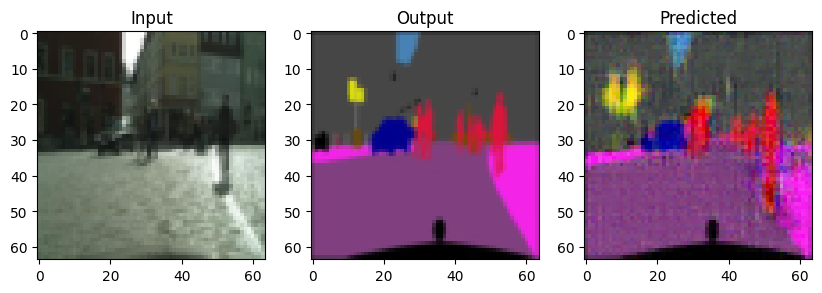

Starting epoch 76...


g_loss: 4.202044486999512, d_loss: 0.31481581926345825


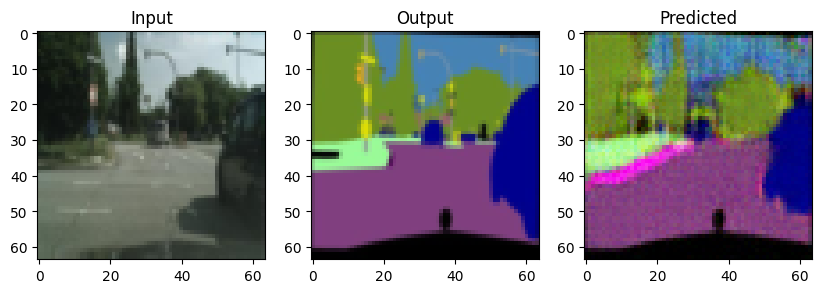

Starting epoch 77...
g_loss: 4.122076511383057, d_loss: 0.3560381531715393


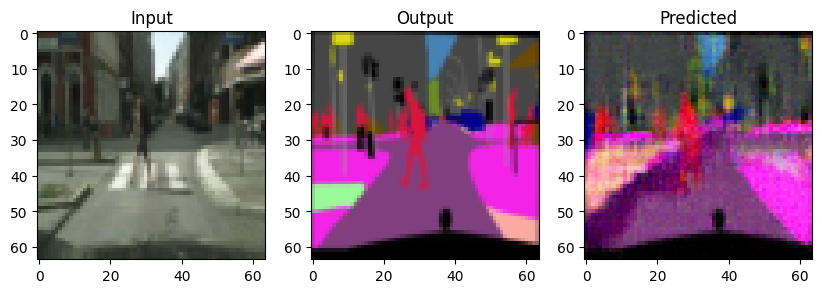

Starting epoch 78...


g_loss: 0.5092424154281616, d_loss: 0.756797194480896


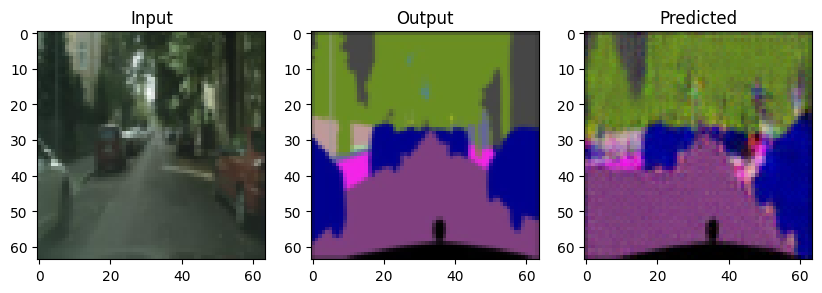

Starting epoch 79...


g_loss: 8.185230255126953, d_loss: 0.7309547066688538


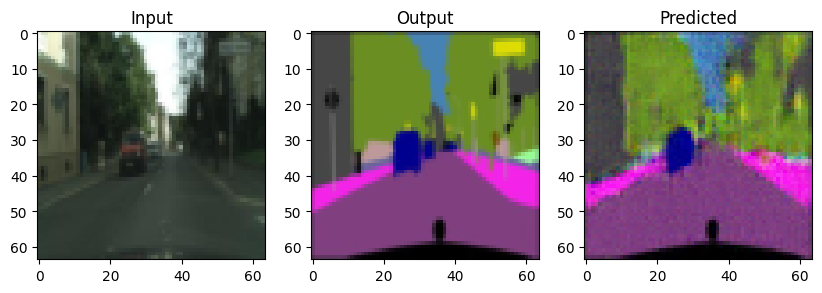

Starting epoch 80...


g_loss: 4.244367599487305, d_loss: 0.32020998001098633


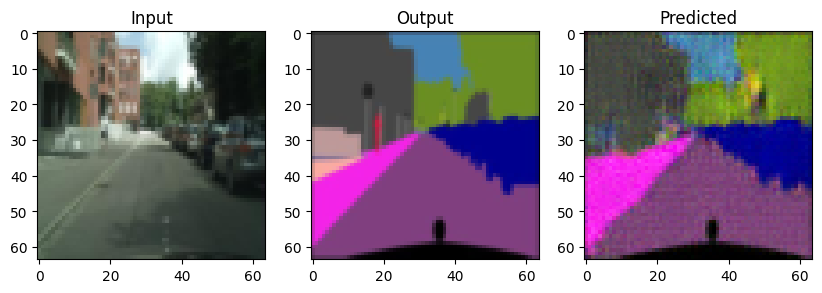

Starting epoch 81...


g_loss: 5.878520965576172, d_loss: 0.5299956202507019


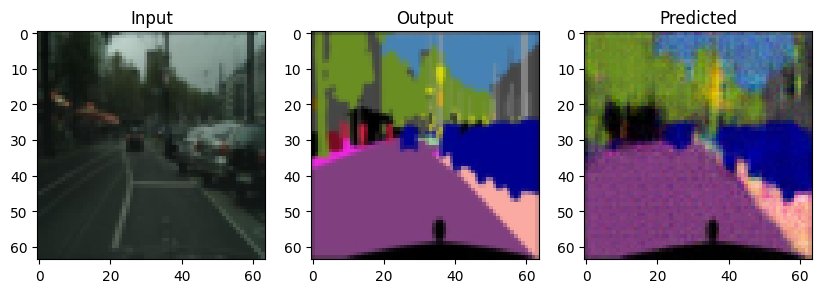

Starting epoch 82...


g_loss: 11.151623725891113, d_loss: 1.2272415161132812


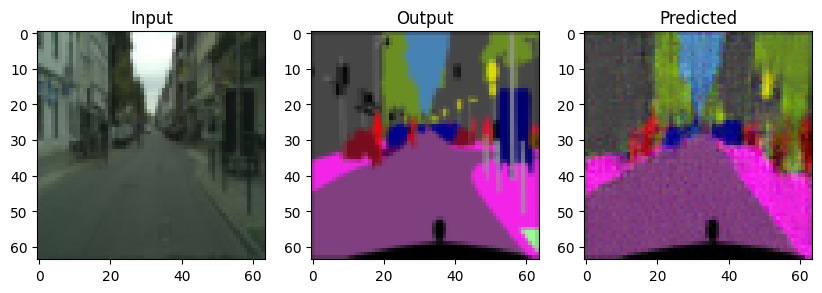

Starting epoch 83...
g_loss: 9.01402473449707, d_loss: 0.6375619173049927


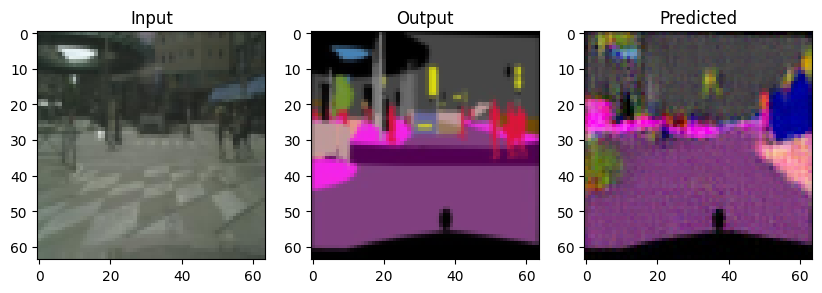

Starting epoch 84...


g_loss: 0.20038454234600067, d_loss: 1.1193739175796509


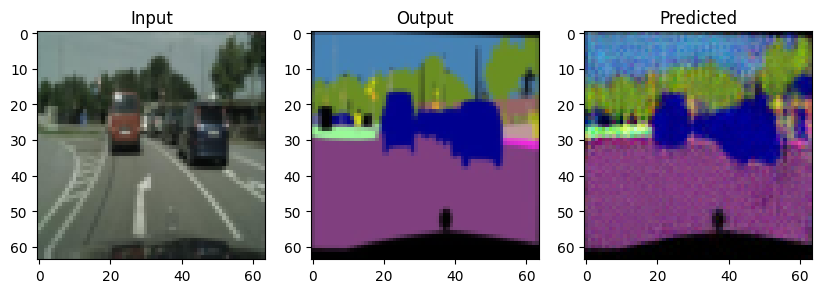

Starting epoch 85...
g_loss: 9.397625923156738, d_loss: 0.7639052867889404


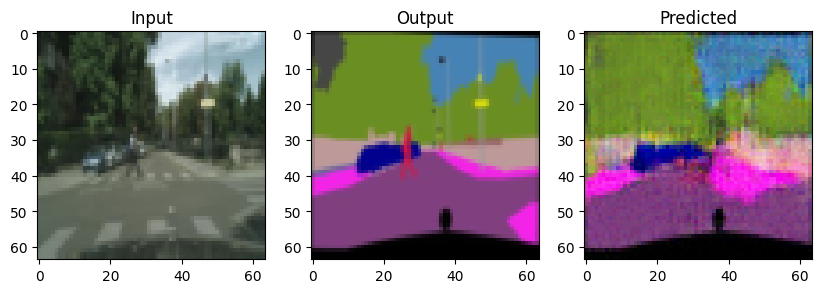

Starting epoch 86...


g_loss: 2.6805665493011475, d_loss: 0.5303826928138733


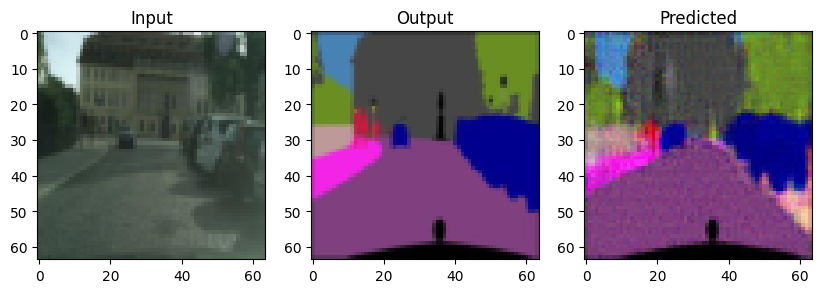

Starting epoch 87...


g_loss: 0.08283815532922745, d_loss: 0.8953376412391663


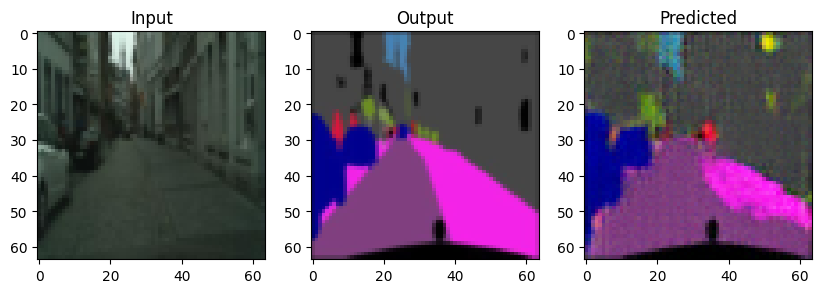

Starting epoch 88...
g_loss: 3.4956932067871094, d_loss: 0.743782103061676


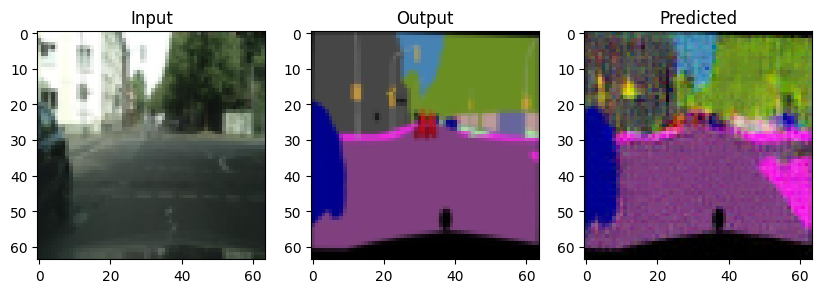

Starting epoch 89...


g_loss: 0.02725652977824211, d_loss: 0.8270083069801331


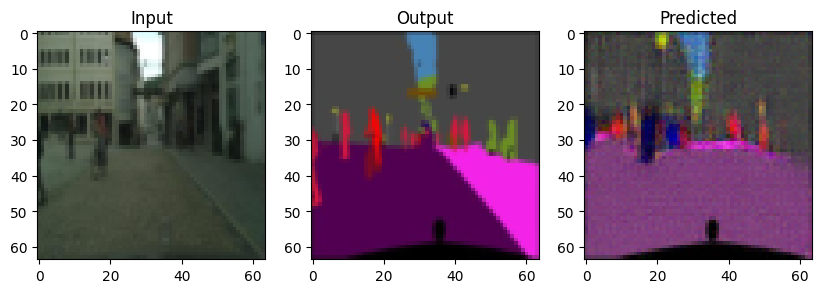

Starting epoch 90...
g_loss: 2.1513943672180176, d_loss: 0.8824151754379272


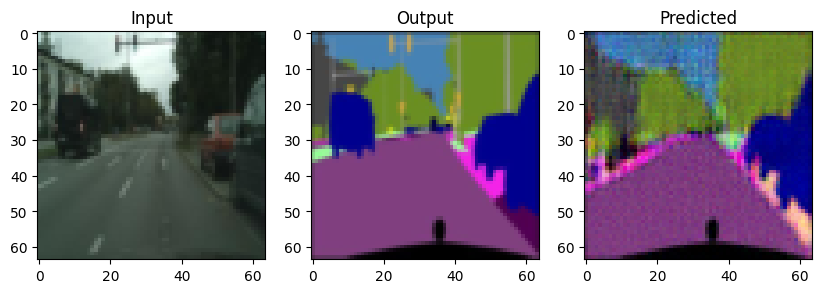

Starting epoch 91...


g_loss: 0.6744813919067383, d_loss: 0.7016022801399231


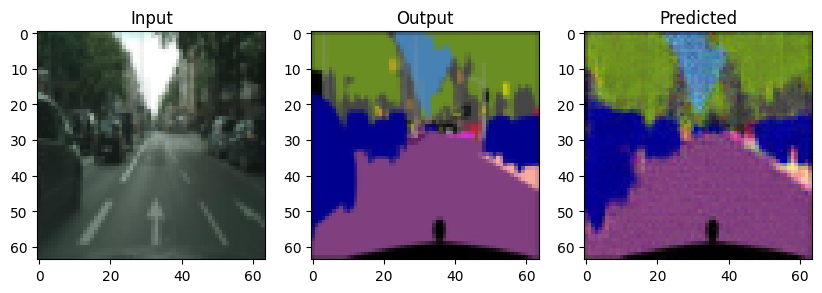

Starting epoch 92...
g_loss: 3.372893810272217, d_loss: 0.6744402647018433


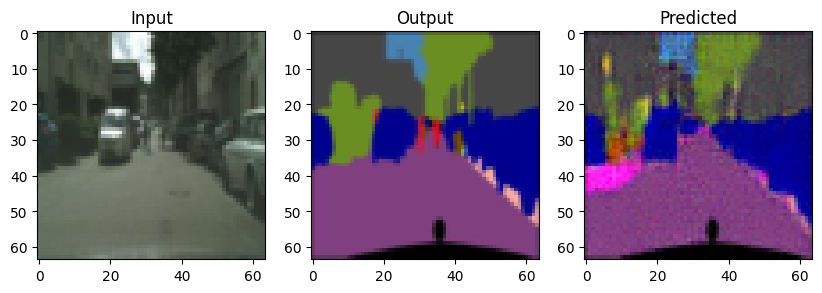

Starting epoch 93...
g_loss: 2.4370312690734863, d_loss: 0.36086782813072205


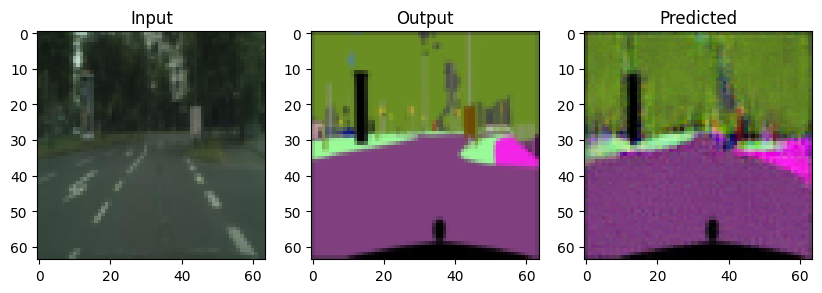

Starting epoch 94...
g_loss: 0.007070950232446194, d_loss: 1.3473929166793823


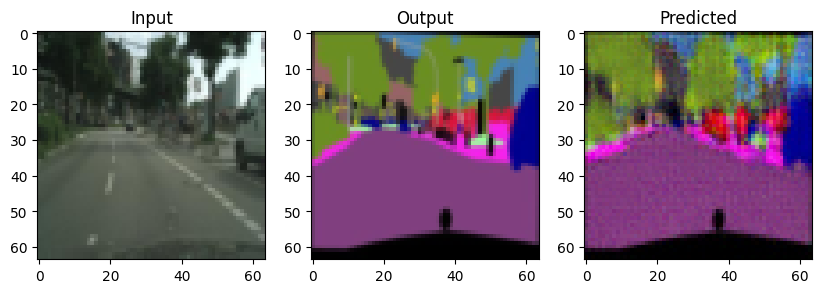

Starting epoch 95...


g_loss: 0.01955474354326725, d_loss: 2.643489360809326


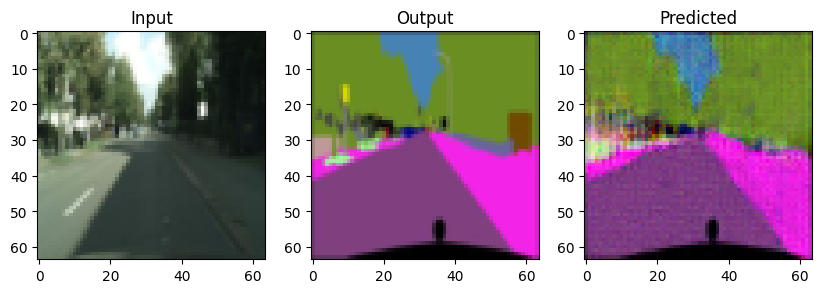

Starting epoch 96...


g_loss: 4.0193963050842285, d_loss: 0.4039943218231201


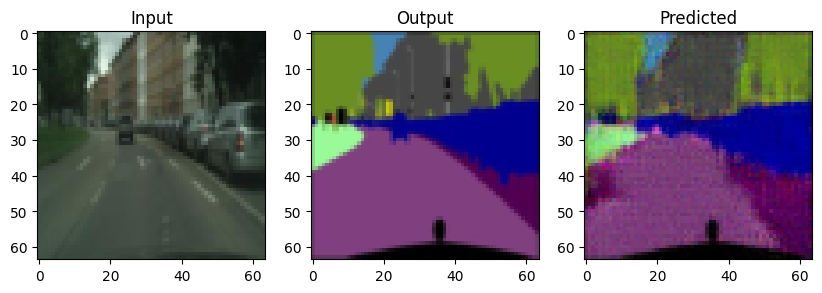

Starting epoch 97...


g_loss: 0.9306502342224121, d_loss: 0.521272599697113


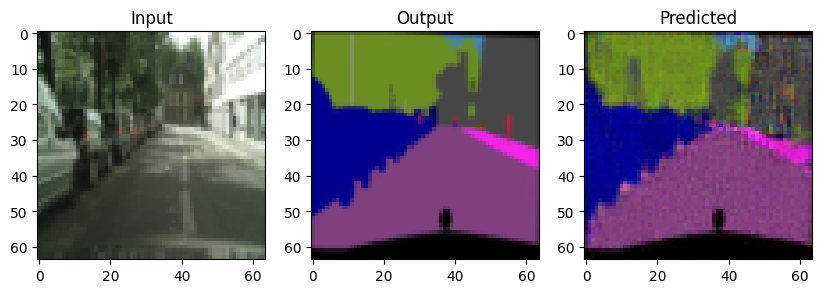

Starting epoch 98...
g_loss: 0.018428828567266464, d_loss: 1.3385213613510132


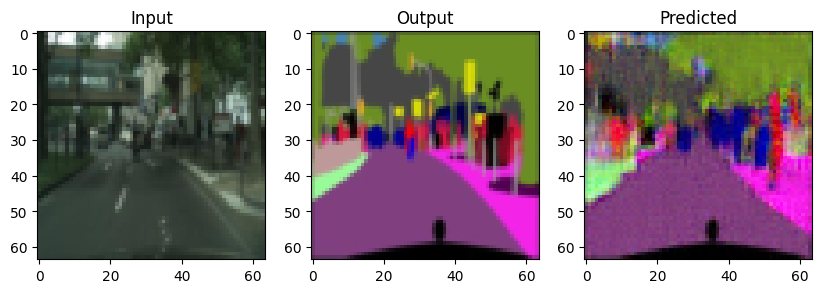

Starting epoch 99...


g_loss: 0.24201563000679016, d_loss: 0.9634956121444702


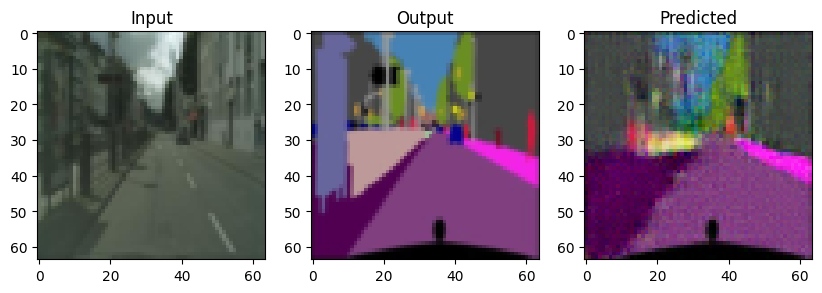

Starting epoch 100...


g_loss: 3.7410054206848145, d_loss: 0.8354707956314087


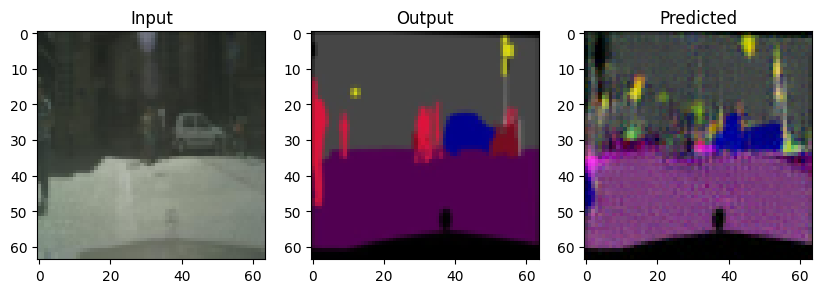

Starting epoch 101...
g_loss: 0.41830092668533325, d_loss: 0.5334343910217285


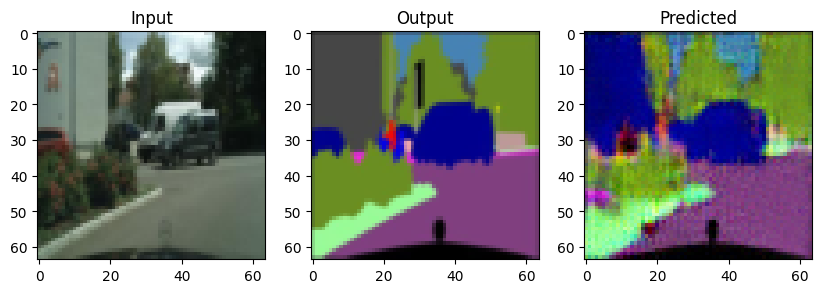

Starting epoch 102...


g_loss: 1.4381849765777588, d_loss: 0.6991119384765625


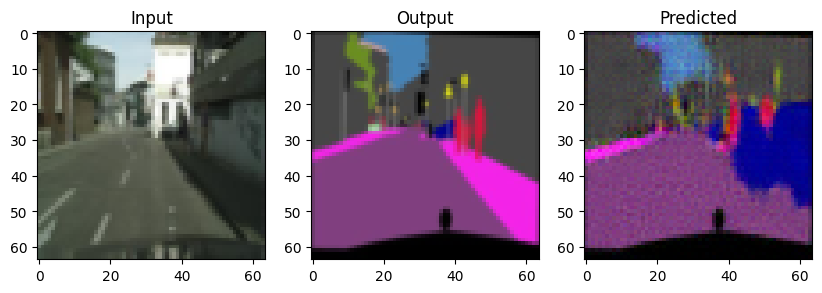

Starting epoch 103...
g_loss: 3.533163070678711, d_loss: 0.46506521105766296


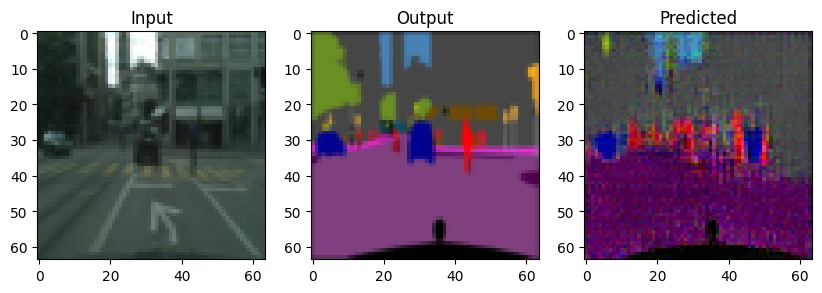

Starting epoch 104...


g_loss: 4.7464494705200195, d_loss: 0.3538869619369507


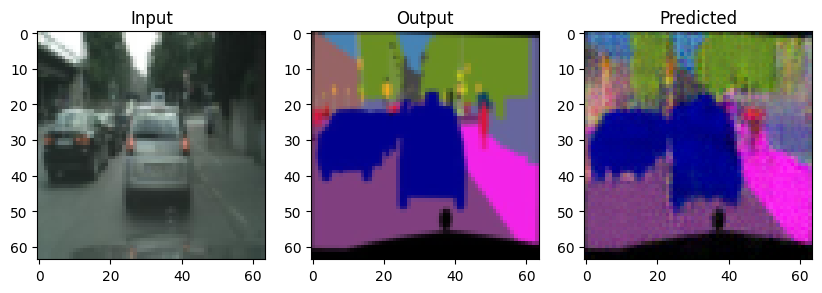

Starting epoch 105...


g_loss: 2.2572312355041504, d_loss: 0.23405760526657104


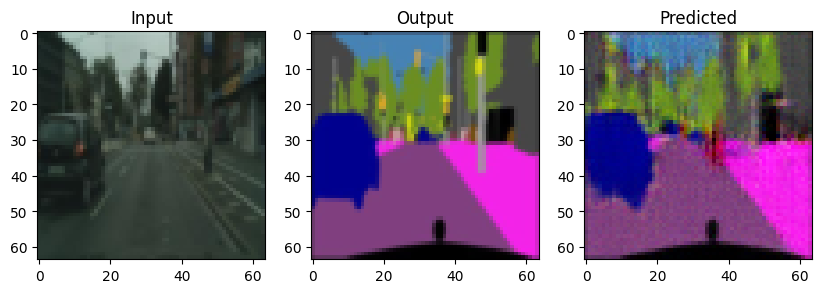

Starting epoch 106...


g_loss: 2.573939561843872, d_loss: 0.5234718322753906


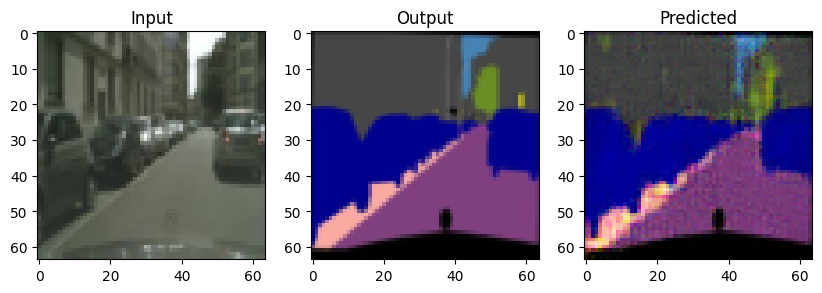

Starting epoch 107...


g_loss: 0.17210997641086578, d_loss: 0.6678550839424133


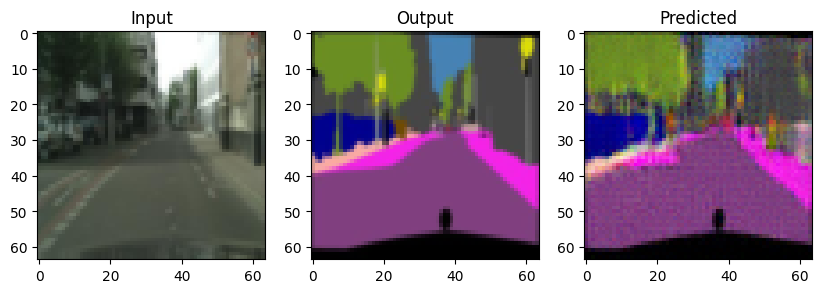

Starting epoch 108...
g_loss: 5.763103485107422, d_loss: 1.3540630340576172


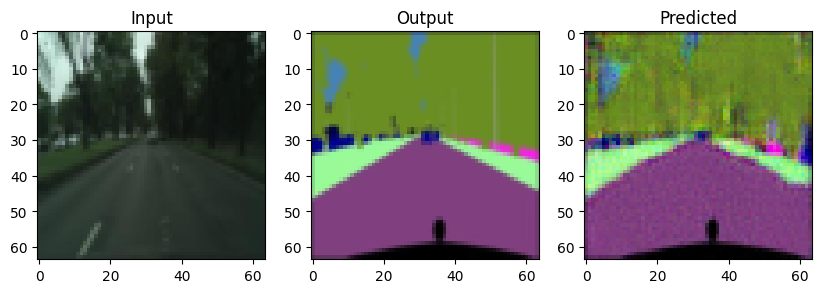

Starting epoch 109...


g_loss: 12.375024795532227, d_loss: 1.9745091199874878


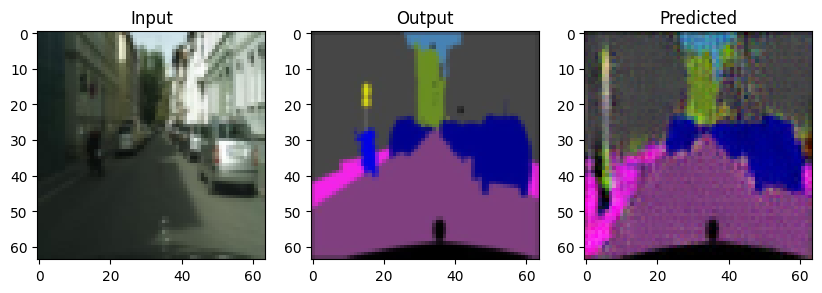

Starting epoch 110...


g_loss: 4.631676197052002, d_loss: 0.12870697677135468


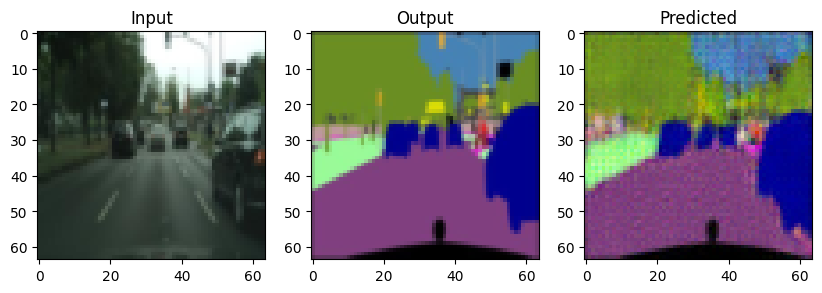

Starting epoch 111...


KeyboardInterrupt: 

In [20]:
#Training GAN
print("Starting Training Loop...")

n_of_epochs = 110
loss_Discriminator = 0

for e in range(n_of_epochs):
    running_loss_D = 0.0
    print('Starting epoch {}...'.format(e+1))
    for i, (input,output) in enumerate(train_loader, 0):

    #####################################################################
    ## Update Discriminator: maximize log(D(x/y)) + log(1 - D(G(z/y))) ##
    #####################################################################

        #Loss on real Images
        myDiscriminator.zero_grad()
        predicted = myDiscriminator(input.to(device),output.to(device))
        loss_real = criterion(predicted, torch.ones((len(predicted)), 1, 1,1, dtype=torch.float, device=device).to(device))
        loss_real.backward(retain_graph=True)

        #Loss on fake Images
        fake_output = myGenerator(input.to(device))
        predicted = myDiscriminator(input.to(device),fake_output.to(device))
        loss_fake = criterion(predicted, torch.zeros((len(predicted)), 1, 1,1, dtype=torch.float, device=device).to(device))
        loss_fake.backward(retain_graph=True)
        loss_Discriminator = loss_real + loss_fake
        d_optimizer.step()

        #################################################
        ### Update Generator: maximize log(D(G(z/y))) ###
        #################################################

        myGenerator.zero_grad()
        predicted = myDiscriminator(input.to(device),fake_output.to(device))
        loss_gen = criterion(predicted, torch.ones((len(predicted)), 1, 1,1, dtype=torch.float, device=device).to(device))
        loss_gen.backward()
        g_optimizer.step()
        running_loss_D +=  loss_Discriminator.item()
    # Set generator eval

    print('g_loss: {}, d_loss: {}'.format(loss_gen, loss_Discriminator))

    # Generate random noise and labels
    data_iter = iter(train_loader)
    input, output = next(data_iter)
    input = input.to(device)
    output = output.to(device)
    # Forward pass through the generator
    generated_image = myGenerator(input).data.cpu().to(device)
    show([input[0], output[0], generated_image[0]])
    plt.show()

In [21]:
torch.save(myGenerator.state_dict(), '/content/drive/MyDrive/cGAN_Gen_segmentation.pth')
torch.save(myDiscriminator.state_dict(), '/content/drive/MyDrive/cGAN_Dis_segmentation.pth')

In [22]:
loaded_Generator = Generator(ngf, img_size, nc).to(device)
loaded_Generator.load_state_dict(torch.load('/content/drive/MyDrive/cGAN_Gen_segmentation.pth'))

loaded_Discriminator = Discriminator(ngpu, img_size, nc).to(device)
loaded_Discriminator.load_state_dict(torch.load('/content/drive/MyDrive/cGAN_Dis_segmentation.pth'))

<All keys matched successfully>

In [40]:
def pixel_wise_accuracy(prediction, target):
    """
    Compute Pixel-wise Accuracy.

    Args:
        prediction (numpy array or torch tensor): Predicted labels.
        target (numpy array or torch tensor): Ground truth labels.

    Returns:
        float: Pixel-wise Accuracy.
    """
    if isinstance(prediction, torch.Tensor):
        prediction = prediction.cpu().numpy()

    if isinstance(target, torch.Tensor):
        target = target.cpu().numpy()

    lower_bound = -7/255
    upper_bound = 7/255

    correct_pixels = np.sum((prediction >= target + lower_bound) & (prediction <= target + upper_bound))
    total_pixels = np.prod(prediction.shape)


    return correct_pixels / total_pixels

In [39]:
accuracies = []
count_data = []
for i, (input,output) in enumerate(train_loader, 0):
  input = input.to(device)
  output = output.to(device)
  #Forward pass through the generator
  generated_image = loaded_Generator(input).data.cpu().to(device)

  #Compute Pixel Accuracy
  accuracy = pixel_wise_accuracy(generated_image, output)
  accuracies.append(accuracy)
  count_data.append(len(input))
total_accuracy = 0
for i in range(len(accuracies)):
  total_accuracy += accuracies[i]*count_data[i]
total_accuracy = total_accuracy/np.sum(count_data)
print(f"Pixel-wise Accuracy on Trainset: {total_accuracy * 100:.2f}%")

Pixel-wise Accuracy on Trainset: 46.57%


In [41]:
accuracies = []
count_data = []
for i, (input,output) in enumerate(valid_loader, 0):
  input = input.to(device)
  output = output.to(device)
  #Forward pass through the generator
  generated_image = loaded_Generator(input).data.cpu().to(device)

  #Compute Pixel Accuracy
  accuracy = pixel_wise_accuracy(generated_image, output)
  accuracies.append(accuracy)
  count_data.append(len(input))
total_accuracy = 0
for i in range(len(accuracies)):
  total_accuracy += accuracies[i]*count_data[i]
total_accuracy = total_accuracy/np.sum(count_data)
print(f"Pixel-wise Accuracy on Validationset: {total_accuracy * 100:.2f}%")

Pixel-wise Accuracy on Validationset: 36.96%
